In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

# Load data sets

In [2]:
dir_path = "./data/Takeout/Fitbit/"

In [3]:
def getData(directory, fileregex:str, timestampColumn:str, csv=True, json=False, indexCol:str=''):
    # load data
    files = [f for f in os.listdir(directory) if re.match(f'{fileregex}', f)]
    if csv:
        dfs = [pd.read_csv(directory+filename) for filename in files]
    elif json:
        dfs = [pd.read_json(directory+filename) for filename in files]

    if indexCol:
        data = pd.concat([dfs[i] for i in range(len(dfs))], index=indexCol)
    else:
        data = pd.concat([dfs[i] for i in range(len(dfs))], ignore_index=True)


    try:
        data['timeCode'] = pd.to_datetime(data[timestampColumn])
        data = data.dropna(subset=[timestampColumn]) # remove any null sampels, as this creates error when .date() or .time()
        data['Date'] = data.timeCode.apply(lambda x: x.date())
        print(f'Datetime for {fileregex} was created.')
    except:
        print(f'Datetime could not be transformed for {fileregex}')
    return data


In [4]:

stress = getData(dir_path+'Stress Score/', fileregex='Stress Score*', timestampColumn='DATE')
sleep = getData(dir_path+'Sleep Score/', fileregex='sleep_score*', timestampColumn='timestamp')
readiness = getData(dir_path+'Daily Readiness/', fileregex='Daily Readiness Score*', timestampColumn='date')
temperatures  = getData(dir_path+'Temperature/', fileregex='Device-*', timestampColumn='recorded_time', csv=True, json=False)

steps  = getData(dir_path+'Global Export Data/', fileregex='steps-*', timestampColumn='Date', csv=False, json=True)
activity = getData(dir_path+'Active Zone Minutes (AZM)/', fileregex='Active Zone Minutes*', timestampColumn='date')


Datetime for Stress Score* was created.
Datetime for sleep_score* was created.
Datetime for Daily Readiness Score* was created.


Datetime for Device-* was created.
Datetime could not be transformed for steps-*
Datetime could not be transformed for Active Zone Minutes*


In [5]:
datedData = [stress,sleep,readiness]

In [6]:
# reduce to only columns of interest
sleep.columns

Index(['sleep_log_entry_id', 'timestamp', 'overall_score', 'composition_score',
       'revitalization_score', 'duration_score', 'deep_sleep_in_minutes',
       'resting_heart_rate', 'restlessness', 'timeCode', 'Date'],
      dtype='object')

In [7]:
readiness = readiness[['Date', 'date', 'readiness_score_value']]
stress = stress[['DATE', 'STRESS_SCORE','timeCode', 'Date', 'SLEEP_POINTS', 'RESPONSIVENESS_POINTS', 'EXERTION_POINTS']]

# Merge data sets

#### merge on created 'Date' column

###### features per day:
- sleep_score
- stress_score
- daily_readiness


In [8]:
df_days = pd.merge(sleep, stress, on='Date')
df_days = pd.merge(df_days, readiness, on='Date')

### Plot over entire data set

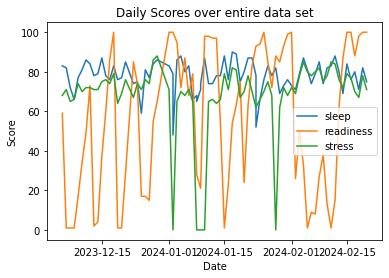

In [9]:
plt.title('Daily Scores over entire data set')
plt.plot(df_days.Date, df_days.overall_score, label='sleep')
plt.plot(df_days.Date, df_days.readiness_score_value, label='readiness')
plt.plot(df_days.Date, df_days.STRESS_SCORE, label='stress')
plt.xlabel('Date')
plt.ylabel('Score')
_= plt.legend()


#### features per Hour/Minute
- activeZoneMinutes
- steps


# Plot per day of week

In [11]:
df_days['weekday'] = df_days.Date.apply(lambda x: x.strftime('%a'))
grouped_days = df_days.groupby('weekday')

In [12]:
df_days.to_csv('sleep_stree_readiness.csv')

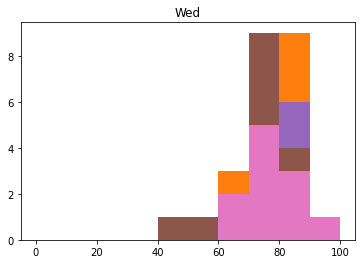

In [13]:
for group in grouped_days:
    plt.hist(group[1].overall_score, range=(0,100))
    plt.title(group[0])
